In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator
from hazma.pseudo_scalar_mediator import PseudoScalarMFV
from hazma.vector_mediator import VectorMediator

from hazma.parameters import neutral_pion_mass as mpi0
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import (energy_res_e_astrogam,
                                                               A_eff_e_astrogam,
                                                               T_obs_e_astrogam,
                                                               gc_target,
                                                               gc_bg_model)
from hazma.gamma_ray_limits.compute_limits import unbinned_limit

In [10]:
def get_tex_label(fs):
    tex_label = r"$"+ fs
    tex_label = tex_label.replace("pi0", "\pi^0")
    tex_label = tex_label.replace("pi pi", "\pi^+ \pi^-")
    tex_label = tex_label.replace("mu mu", "\mu^+ \mu^-")
    tex_label = tex_label.replace("g", "\gamma")
    tex_label = tex_label.replace("e e", "e^+ e^-")
    return tex_label + r"$"

def get_color(fs):
    fss = ["pi0 pi0", "pi pi", "mu mu", "e e", "pi0 g", "g g", "pi0 pi pi", "s s", "v v", "pi0 pi0 pi0", "pi0 pi pi"]
    return list(plt.rcParams["axes.prop_cycle"])[fss.index(fs)]["color"]

Constraint plots are usually computed assuming 100% branching fraction into a single final state. In this notebook, we do this for the scalar and vector simplified models using e-ASTROGAM as our experiment of choice.

## Recompute limits

In [3]:
# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
mxs = np.linspace(mx_min, mx_max, n_mxs)

### Scalar final states

In [5]:
def _constrain_channel_s(mx, fs):
    sm = ScalarMediator(mx, ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)
    
    if fs not in ["g g", "s s"]:
        return unbinned_limit(sm.spectrum_functions()[fs], lambda e_cm: {},
                              sm.mx, False,
                              A_eff_e_astrogam, energy_res_e_astrogam,
                              T_obs_e_astrogam, gc_target, gc_bg_model)
    elif fs == "g g":
        return unbinned_limit(lambda es, e_cm: 0.0,
                              lambda e_cm: {"g g": {"bf": 1.0, "energy": e_cm / 2.0}},
                              sm.mx, False,
                              A_eff_e_astrogam, energy_res_e_astrogam,
                              T_obs_e_astrogam, gc_target, gc_bg_model)
    
def constrain_channel_s(mxs, fs):
    return np.vectorize(lambda mx: _constrain_channel_s(mx, fs))(mxs)

In [6]:
sm_ch_limits = {}

for fs in ScalarMediator.list_final_states():
    if fs not in ["s s"]:
        sm_ch_limits[fs] = constrain_channel_s(mxs, fs)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  lim = prefactor * n_sigma / (-limit_obj.fun)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:43: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:45: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:49: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val


In [ ]:
np.save("data/sm_individual_channel_limits.npy", [mxs, sm_ch_limits])

### Pseudoscalar final states

In [4]:
def _constrain_channel_p(mx, fs):
    psm = PseudoScalarMFV(mx, mp=1e3, gpxx=1., gpqq=1., gpll=0., gpFF=0., gpGG=1.)
    
    if fs in ["pi0 pi0 pi0", "pi0 pi pi"]:
        return unbinned_limit(psm.spectrum_functions()[fs], lambda e_cm: {},
                              psm.mx, False,
                              A_eff_e_astrogam, energy_res_e_astrogam,
                              T_obs_e_astrogam, gc_target, gc_bg_model)
    
def constrain_channel_p(mxs, fs):
    return np.vectorize(lambda mx: _constrain_channel_p(mx, fs))(mxs)

In [5]:
psm_ch_limits = {}

for fs in ["pi0 pi0 pi0", "pi0 pi pi"]:
    psm_ch_limits[fs] = constrain_channel_p(mxs, fs)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  lim = prefactor * n_sigma / (-limit_obj.fun)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:44: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:46: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:50: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/rambo.py:202: RuntimeWarning: invalid value encountered in sqrt
  density=density)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/qua

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.

In [7]:
np.save("data/psm_individual_channel_limits.npy", [mxs, psm_ch_limits])

### Vector final states

In [7]:
def _constrain_channel_v(mx, fs):
    vm = VectorMediator(mx, mv=1000., gvxx=1., gvuu=1., gvdd=1., gvss=1., gvee=1., gvmumu=1.)
    
    if fs not in ["pi0 g", "v v", "pi0 pi pi"]:
        return unbinned_limit(vm.spectrum_functions()[fs], lambda e_cm: {},
                              vm.mx, False,
                              A_eff_e_astrogam, energy_res_e_astrogam,
                              T_obs_e_astrogam, gc_target, gc_bg_model)
    elif fs == "pi0 g":
        return unbinned_limit(vm.spectrum_functions()[fs],
                              lambda e_cm: {"pi0 g": {"bf": 1.0, "energy": (e_cm**2 - mpi0**2) / (2.*e_cm)}},
                              vm.mx, False,
                              A_eff_e_astrogam, energy_res_e_astrogam,
                              T_obs_e_astrogam, gc_target, gc_bg_model)
    
def constrain_channel_v(mxs, fs):
    return np.vectorize(lambda mx: _constrain_channel_v(mx, fs))(mxs)

In [8]:
vm_ch_limits = {}

for fs in VectorMediator.list_final_states():
    if fs not in ["v v", "pi0 pi pi"]:
        vm_ch_limits[fs] = constrain_channel_v(mxs, fs)

In [9]:
np.save("data/vm_individual_channel_limits.npy", [mxs, vm_ch_limits])

## Load and plot precomputed results

In [8]:
mxs, sm_ch_limits = np.load("data/sm_individual_channel_limits.npy")
mxs, psm_ch_limits = np.load("data/psm_individual_channel_limits.npy")
mxs, vm_ch_limits = np.load("data/vm_individual_channel_limits.npy")

# sm_mxs, sm_limits = np.loadtxt("data/sm_lims_e_astrogam.csv", delimiter=",").T
# vm_mxs, vm_limits = np.loadtxt("data/vm_lims_e_astrogam.csv", delimiter=",").T

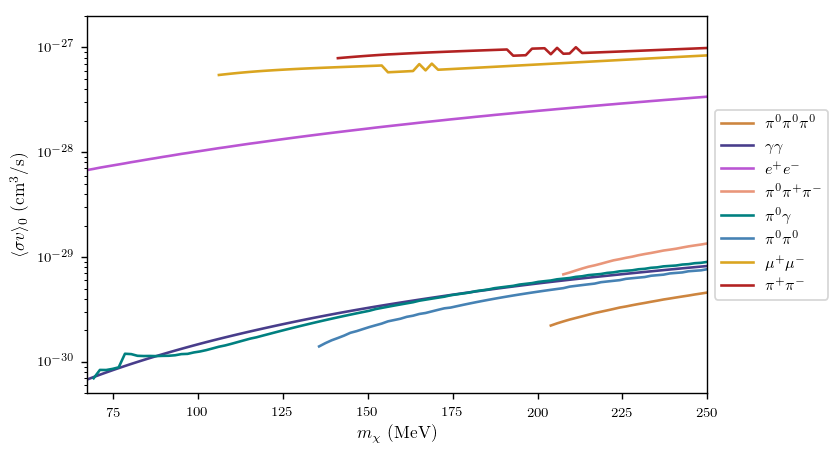

In [13]:
plt.figure(figsize=(8, 4))

fs_list = [fs for fs in list(set(ScalarMediator.list_final_states() +
                                 VectorMediator.list_final_states() +
                                 PseudoScalarMFV.list_final_states()))
           if fs not in ["s s", "v v", "p p"]]

# Individual channel limits
for fs in fs_list:
    if fs in ScalarMediator.list_final_states() and fs in VectorMediator.list_final_states():
        plt.plot(mxs, sm_ch_limits[fs], color=get_color(fs), label=get_tex_label(fs), linewidth=1.5)
    elif fs in ScalarMediator.list_final_states():
        plt.plot(mxs, sm_ch_limits[fs], color=get_color(fs), label=get_tex_label(fs), linewidth=1.5)
    elif fs in VectorMediator.list_final_states():
        plt.plot(mxs, vm_ch_limits[fs], color=get_color(fs), label=get_tex_label(fs), linewidth=1.5)
    elif fs in PseudoScalarMFV.list_final_states():
        plt.plot(mxs, psm_ch_limits[fs], color=get_color(fs), label=get_tex_label(fs), linewidth=1.5)

plt.yscale("log")
plt.xlim(mxs[[0, -1]])
plt.ylim(5e-31, 2e-27)
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")
# plt.title("e-ASTROGAM limits on individual channels")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("figures/individual_channel_constraints.pdf")

In [11]:
import os
os.system('say "Done computing limits"')

0

## Debugging

In [ ]:
from hazma.scalar_mediator.scalar_mediator_fsr import dnde_xx_to_s_to_pipig
from hazma.vector_mediator.vector_mediator_fsr import dnde_xx_to_v_to_pipig

from hazma.scalar_mediator import ScalarMediator
from hazma.vector_mediator import VectorMediator

import numpy as np

In [ ]:
mx = 150.
sm = ScalarMediator(mx, ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)

for v in [1e-3, 1e-2, 1e-1]:
    e_cm = 2.*mx*(1+0.5*v**2)
    print("dN/dE = %e" % dnde_xx_to_s_to_pipig(1e-1, e_cm, sm))
    print("sigma = %e" % sm.cross_sections(e_cm)["pi pi"])
    print("")

In [ ]:
mx = 150.
e_cm = 2.*mx*(1+0.5*1e-6)

sm = ScalarMediator(mx, ms=1000., gsxx=1., gsff=1., gsGG=1., gsFF=1.)
vm = VectorMediator(mx, mv=1000., gvxx=1., gvuu=1., gvdd=1., gvss=1., gvee=1., gvmumu=1.)

e_gams = np.logspace(0, np.log10(200), 250)

plt.loglog(e_gams, e_gams * dnde_xx_to_s_to_pipig(e_gams, e_cm, sm), '--', label="Scalar (FSR)")
plt.loglog(e_gams, e_gams * dnde_xx_to_v_to_pipig(e_gams, e_cm, sm), '--', label="Vector (FSR)")

plt.title(r"$m_\chi=%f$, $E_{\mathrm{CM}} = %f$" % (mx, e_cm))
plt.xlabel(r"$E_\gamma$")
plt.ylabel(r"$dN/dE_\gamma$ (MeV$^{-1}$)")
plt.legend()

In [ ]:
import os
os.system('say "Done computing limits"')